<a href="https://colab.research.google.com/github/busung/emotinal_classification/blob/main/%ED%95%99%EB%B6%80%EC%97%B0%EA%B5%AC%EC%83%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,SimpleRNN
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
test=pd.read_csv('/content/gdrive/MyDrive/학부연구/test.csv')
train = pd.read_csv('/content/gdrive/MyDrive/학부연구/train.csv')

In [ ]:
train.head(50)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
#결측치 확인 및 제거
train.isnull().any()
#test와 train set 모두 결측치가 없으므로 처리할 것 없음

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [ ]:
#train data를 X(문장)과 Y(결과값)으로 분해함
list_classes = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
y=train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

In [ ]:
list_sentences_train

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
list_sentences_test

0         Yo bitch Ja Rule is more succesful then you'll...
1         == From RfC == \n\n The title is fine as it is...
2         " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3         :If you have a look back at the source, the in...
4                 I don't anonymously edit articles at all.
                                ...                        
153159    . \n i totally agree, this stuff is nothing bu...
153160    == Throw from out field to home plate. == \n\n...
153161    " \n\n == Okinotorishima categories == \n\n I ...
153162    " \n\n == ""One of the founding nations of the...
153163    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 153164, dtype: object

In [ ]:
y.shape

(159571, 6)

In [ ]:
#토큰화 => 토큰된 단어의 인덱싱 => 주어진 문장을 인덱싱 번호로 변환
#케라스에선 이 과정을 지원해 줌
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)#문장을 토큰화 시킴
tokenizer.fit_on_texts(list(list_sentences_train))#토큰화된 단어들을 인덱싱 시킴
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)#train문장을 인덱싱 시킴
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)#test문장을 인덱싱 시킴

In [ ]:
#문장이 각 단어의 인덱스로 변환된 것을 확인 할 수 있음
print(list_tokenized_train[:1])

[[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]]


In [ ]:
#문장의 길이가 모두 다르기에 lstm에 넣을 수가 없음 이렇게 문장의 길이를 맞추기 위해
#공백을 만들어 의미없는 숫자를 맞추는 것이 패딩
maxlen = 200
X_t = pad_sequences(list_tokenized_train,maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test,maxlen=maxlen)

In [ ]:
X_t[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

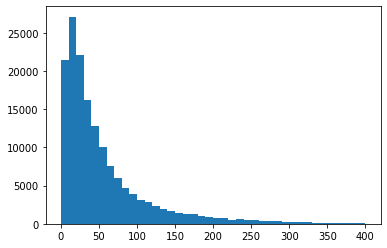

In [ ]:
#위의 maxlen의 길이는 문장 길이의 분포를 보고 설정
#너무 길다 => 학습 속도 저하 및 저장 공간 부족, 너무 짧다 => 데이터 손실 발생
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins=np.arange(0,410,10))
plt.show()
#분포를 보면 30이상에서 가장 많긴 하나 위의 과정에선 정보의 손실이 더 걱정되어 200으로 설정
#많이 실험과 경험을 통해 결정하면 됨

#input이 거쳐가는 과정
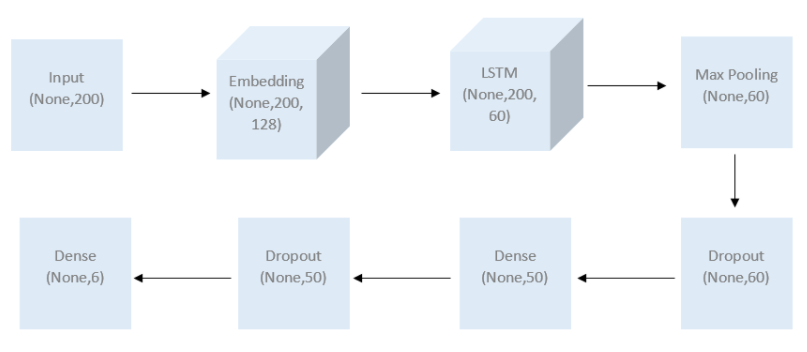

1. 길이가 200으로 패딩된 input을 넣는다
2. 이것을 임베딩시켜 벡터로 만든다
3. 임베딩 벡터를 lstm에 넣어 학습시킨다
4. Max Pooling을 이용하여 차원을 감소시킨다
5. Dropout을 적용(과적합 방지 및 성능 향상)
6. relu. 적용
7. Dropout
8. sigmoid를 통한 우리가 원하는 output생성
(현재 y가 6개의 컬럼으로 0,1한 값을 가지므로)

- linear : 디폴트 값으로 별도 활성화 함수 없이 입력 뉴런과 가중치의 계산 결과 그대로 출력. Ex) 선형 회귀
- sigmoid : 시그모이드 함수. 이진 분류 문제에서 출력층에 주로 사용되는 활성화 함수.
- softmax : 소프트맥스 함수. 셋 이상을 분류하는 다중 클래스 분류 문제에서 출력층에 주로 사용되는 활성화 함수.
- relu : 렐루 함수. 은닉층에 주로 사용되는 활성화 함수.

## SimpleRNN

In [ ]:
model = tf.keras.Sequential()

In [ ]:
model.add(Embedding(max_features, 128, input_length = 200))
model.add(SimpleRNN(units=60,activation='relu'))

NameError: ignored

## lstm

In [ ]:
#keras에게 input size를 알려준다
inp = Input(shape=(maxlen,))

In [ ]:
#임베딩(단어를 밀집 벡터의 형태로 표현하는 방법) => 원-핫 인코딩과 달리 진짜 벡터로써 거리를 이용할 수 도 있음
embed_size = 128
x=Embedding(max_features,embed_size)(inp)
x.shape

TensorShape([None, 200, 128])

In [ ]:
#60 = 우리가 정하는 출력 차원
x=LSTM(128,return_sequences=True,name='lstm_layer')(x)
x.shape

TensorShape([None, 200, 128])

In [ ]:
#출력은 3차원 tensor이기 때문에 이를 2차원으로 낮추어 줘야함
#차원을 축소하면 정보의 손실이 일어나는데 이를 줄이기 위해서 Max Pooling을 이용(이것 말고 Average,Max,etc 등등을 활용함)
x=GlobalMaxPool1D()(x)
x.shape

TensorShape([None, 128])

In [ ]:
#데이터의 일부를 무작위적으로 못 쓰게 만들어서 다음층에 이 결측치를 다루게 만들고 전체 네트워크가 더 나은 결과를 만들게 해줌
#여기선 10%의 손실을 가함
x=Dropout(0.2)(x)
x.shape

TensorShape([None, 128])

In [ ]:
#relu 함수를 적용, 차원을 50으로 낮춤
x=Dense(50,activation='relu')(x)
x.shape

TensorShape([None, 50])

In [ ]:
x=Dropout(0.2)(x)
x.shape

TensorShape([None, 50])

In [ ]:
#시그모이드 함수를 이용하여 ouput을 0,1로 바꿔줌 => 위의 y즉 6가지 column 값이 0 인지 1인지 판단해줌
#우리가 원하는 결과값이 binary이기 때문에
x=Dense(6,activation='sigmoid')(x)
x.shape

TensorShape([None, 6])

In [ ]:
model = Model(inputs = inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_path = '{epoch}-{val_loss}.hdf5'

# Validation Loss를 기준으로 조건 판단.
callback1 = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)

# 이전 가장 좋은 결과 대비 10회 이상 후에도 향상 되는 결과가 나오지 않을시 학습 중단.
callback2 = EarlyStopping(monitor = 'val_loss', patience=5)

In [ ]:
batch_size = 32
epochs = 20
history=model.fit(X_t,y,batch_size=batch_size,epochs=epochs,validation_split=0.1,callbacks = [callback1, callback2])

Epoch 1/20
4488/4488 [==============================] - 1232s 274ms/step - loss: 0.0709 - accuracy: 0.9342 - val_loss: 0.0503 - val_accuracy: 0.9940

Epoch 00001: val_loss improved from inf to 0.05031, saving model to 1-0.05030584707856178.hdf5
Epoch 2/20
4488/4488 [==============================] - 1230s 274ms/step - loss: 0.0481 - accuracy: 0.9914 - val_loss: 0.0490 - val_accuracy: 0.9940

Epoch 00002: val_loss improved from 0.05031 to 0.04895, saving model to 2-0.04895074665546417.hdf5
Epoch 3/20
4488/4488 [==============================] - 1238s 276ms/step - loss: 0.0433 - accuracy: 0.9742 - val_loss: 0.0480 - val_accuracy: 0.9940

Epoch 00003: val_loss improved from 0.04895 to 0.04795, saving model to 3-0.04795246943831444.hdf5
Epoch 4/20
4488/4488 [==============================] - 1266s 282ms/step - loss: 0.0390 - accuracy: 0.9729 - val_loss: 0.0507 - val_accuracy: 0.9940

Epoch 00004: val_loss did not improve from 0.04795
Epoch 5/20
4488/4488 [==============================] - 

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_t,y)

4987/4987 [==============================] - 331s 66ms/step - loss: 0.0300 - accuracy: 0.9712


[0.030006036162376404, 0.9711915254592896]

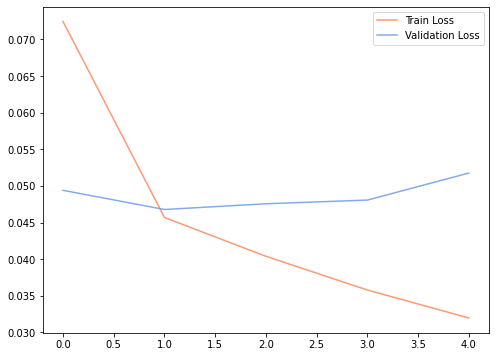

In [ ]:
# Train Loss
y_loss = history.history['loss']
# Validation Loss
y_vloss = history.history['val_loss']

plt.figure(figsize=(8,6))
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss,  label='Train Loss', c='coral', alpha=.8)
plt.plot(x_len, y_vloss,  label='Validation Loss', c='cornflowerblue', alpha=.8)
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [ ]:
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input],[model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 200, 60)